# 02750 HW1

## Exercise 2 Passive vs Active Learning (Classification)

#### Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
import random
from sklearn.preprocessing import LabelEncoder
import tqdm

#### Data

In [3]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = pd.read_csv("iris/iris.data", header=None, names=column_names)
shuffled_data = shuffle(data, random_state=42)

In [4]:
random_seeds = []
for i in range(5):
    random.seed(100*i)
    random_seeds.append(random.randint(1, 10))
random_seeds

[7, 3, 1, 10, 5]

#### Passive Learning 

In [5]:
def classification_passive_learning(d, seed):
    # Store average cross fold validation accuracy
    cross_fold_acc = [] 
    # Store average test accuracy using Unseen data
    test_acc = []
    d = shuffle(data, random_state=seed)

    # Start with 20% of the data 
    sample_data, remaining_data = train_test_split(d, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
    
    # Run the loop while the sample_data includes 50% of the original data
    while len(sample_data) <= len(d) /2 :
        # Store accuracy from individual fold 
        fold_acc = []
        cross_val = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        for train, test in cross_val.split(sample_data_X):
            features_train, features_test = sample_data_X.iloc[train], sample_data_X.iloc[test]
            labels_train, labels_test = sample_data_y.iloc[train], sample_data_y.iloc[test]
            
            model = RandomForestClassifier(random_state=None)
            model.fit(features_train, labels_train)
            y_pred = model.predict(features_test)
            acc = accuracy_score(labels_test, y_pred)
            fold_acc.append(acc)
            
        # Get the average cross fold accuracy on the training data
        avg_cross_fold_acc = np.mean(fold_acc)
        cross_fold_acc.append(avg_cross_fold_acc)

        # Predict on the 80% of the data 
        X_train, y_train = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        X_test, y_test = remaining_data.iloc[:, :-1], remaining_data.iloc[:, -1]

        # Get the accuracy score on the unseen data 
        mod = RandomForestClassifier(random_state=None)
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_acc.append(test_accuracy)
        

        # Move one instance from test data to training data 
        instance_to_add = remaining_data.sample(n=1)
        sample_data = pd.concat([sample_data, instance_to_add], ignore_index=True) 
        remaining_data = remaining_data.drop(instance_to_add.index)
        

    return cross_fold_acc, test_acc


##### Active Learning (Uncertainty Sampling)

In [6]:
def get_entropies(labels_probs):
    entropies = [] 
    epsilon = 0.0001
    for i in labels_probs:
        prod = i * np.log2(i+epsilon)
        entropies.append(-np.sum(prod))
    return entropies
        

In [7]:
import numpy as np

def classification_active_learning(d, seed):
    # Store average cross fold validation accuracy on the training data
    cross_fold_acc = [] 
    # Store test accuracy on the unseen data
    test_acc = []
    d = shuffle(d, random_state=seed)

    # Start with 20% of the data 
    sample_data, remaining_data = train_test_split(d, test_size=0.8, random_state=seed)
    sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]

    # Run the loop until the sample data includes 50% of the original data 
    while len(sample_data) <= len(d) / 2:
        # Store accuracy score from individual fold
        fold_acc = []
        cross_val = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        for train, test in cross_val.split(sample_data_X):
            features_train, features_test = sample_data_X.iloc[train], sample_data_X.iloc[test]
            labels_train, labels_test = sample_data_y.iloc[train], sample_data_y.iloc[test]
            
            model = RandomForestClassifier(random_state=None)
            model.fit(features_train, labels_train)
            y_pred = model.predict(features_test)
            acc = accuracy_score(labels_test, y_pred)
            fold_acc.append(acc)
            
        # Get the average of the fold accuracies on the training data
        avg_cross_fold_acc = np.mean(fold_acc)
        cross_fold_acc.append(avg_cross_fold_acc)

        # Training a model on the current sample data
        X_train, y_train = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        X_test, y_test = remaining_data.iloc[:, :-1], remaining_data.iloc[:, -1]

        mod = RandomForestClassifier(random_state=None)
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_acc.append(test_accuracy) 

        # Predicting class probabilities for the remaining data
        remaining_data_X = remaining_data.iloc[:, :-1]
        labels_probabilities = np.array(mod.predict_proba(remaining_data_X)) # 120 rows, 3 classes (columns)

        # Calculating entropies
        entropies = get_entropies(labels_probabilities)

        # Selecting the point with the highest entropy to add to the sample data 
        highest_entropy_index = np.argmax(entropies)
        sample_to_add = remaining_data.iloc[[highest_entropy_index]]

        # Adding the selected instance to the sample data
        sample_data = pd.concat([sample_data, sample_to_add], ignore_index=True)
        # Remove that point from the remaining data
        remaining_data = remaining_data.drop(sample_to_add.index)
        
    return cross_fold_acc, test_acc


#### Performance Plot of Passive and Active Learning (using Uncertainty Sampling) on a Classification Task

In [8]:
# Running Passive Learning
cv_acc_passive = dict()
test_acc_passive = dict() 

for seed in random_seeds:
    cv_acc, test_accur = classification_passive_learning(shuffled_data, seed)

    cv_acc_passive[seed] = cv_acc 
    test_acc_passive[seed] = test_accur 

train_acc = list(cv_acc_passive.values())
train_avg_acc_passive = np.mean(train_acc, axis=0)

test_acc = list(test_acc_passive.values())
test_avg_acc_passive = np.mean(test_acc, axis=0)

# Running Active Learning 
cv_acc_active = dict()
test_acc_active = dict() 

for seed in random_seeds:
    cv_acc, test_accur = classification_active_learning(shuffled_data, seed)

    cv_acc_active[seed] = cv_acc 
    test_acc_active[seed] = test_accur 

train_acc_uncertainty = list(cv_acc_active.values())
train_avg_acc_active = np.mean(train_acc_uncertainty, axis=0)

test_acc_uncertainty = list(test_acc_active.values())
test_avg_acc_active = np.mean(test_acc_uncertainty, axis=0)


/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_46803/1592449004.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values, test_avg_acc_passive, yerr=np.std(test_avg_acc_passive), label='Unobserved Set Accuracy Passive Learning', fmt='-o', linestyle='-')
/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_46803/1592449004.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values, train_avg_acc_active, yerr=np.std(train_avg_acc_active), label='Cross-Validation Accuracy Active Learning)', fmt='-o', linestyle='-')
/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_46803/1592449004.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string

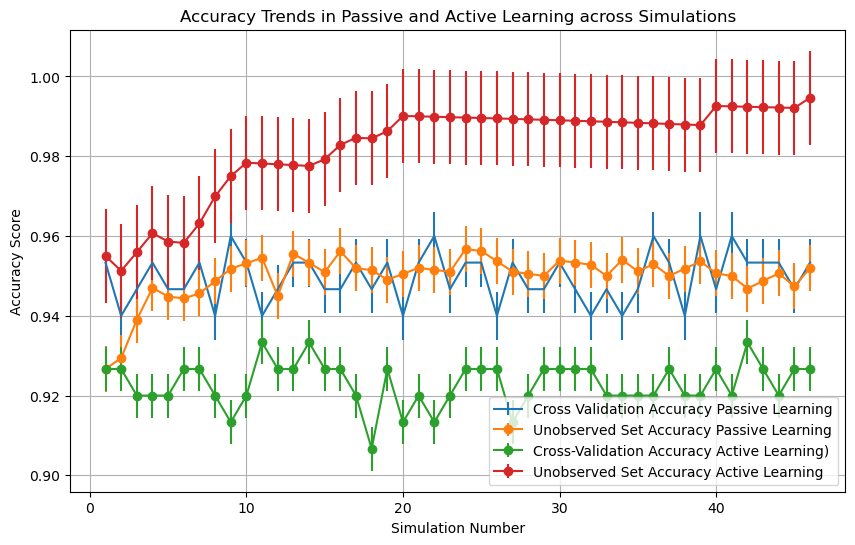

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x_values = list(range(1, 47))

plt.errorbar(x_values, train_avg_acc_passive, yerr=np.std(train_avg_acc_passive), label='Cross Validation Accuracy Passive Learning')
plt.errorbar(x_values, test_avg_acc_passive, yerr=np.std(test_avg_acc_passive), label='Unobserved Set Accuracy Passive Learning', fmt='-o', linestyle='-')
plt.errorbar(x_values, train_avg_acc_active, yerr=np.std(train_avg_acc_active), label='Cross-Validation Accuracy Active Learning)', fmt='-o', linestyle='-')
plt.errorbar(x_values, test_avg_acc_active, yerr=np.std(test_avg_acc_active), label='Unobserved Set Accuracy Active Learning', fmt='-o', linestyle='-')
plt.title('Accuracy Trends in Passive and Active Learning across Simulations')
plt.xlabel('Simulation Number')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()
